In [ ]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

colors = {
    "Rest of World" : "#0072B2",
    "Mexico" : "#56B4E9",
    "Baja California" : "#009E73",
    "San Diego" : "#009E73",
    "Los Angeles" : "#E69F00",
    "United States" : "#D55E00"
}

# Figure 2: Timing and magnitude of Markov jumps into San Diego
Using a discrete phylogeographic analysis, we count the number of markov jumps into San Diego.

Load in the jumps from the discrete state analysis which used actual location states. This table is generated by running the `TreeMarkovJumpHistoryAnalyzer` on the posterior distribution of trees from the discrete-state reconstruction performed with BEAST.

In [2]:
#jumps = pd.read_csv( "../data/2021-08-30_fixed_eponential_discrete.Location.history.csv" )
jumps = pd.read_csv( "../data/2022-08-29_exponential_fixed_discrete.Location.history.csv" )
jumps["date"] = jumps["time"].apply( dec_to_date )
jumps["date"] = jumps["date"].dt.normalize()
#jumps = jumps.loc[jumps["treeId"]>jumps["treeId"].max()*0.1]
jumps.head()

,treeId,startLocation,endLocation,time,date
0,100000,United States,Rest of World,2022.050343,2022-01-19
1,100000,Los Angeles,Rest of World,2021.995021,2021-12-30
2,100000,Los Angeles,Rest of World,2022.190984,2022-03-11
3,100000,United States,Rest of World,2021.295180,2021-04-18
4,100000,San Diego,Rest of World,2022.024106,2022-01-09


In [3]:
def rmse( entry1, entry2 ):
    result = np.power( entry1 - entry2, 2 )
    result = np.average( result )
    return  np.sqrt( result )

def mae( entry1, entry2 ):
    result = np.abs( entry1 - entry2 )
    return np.average( result )

def get_comparison( pair, mat ):
    try:
        first = mat.loc[~mat.index.isin( pair ),pair[0]]
        second = mat.loc[~mat.index.isin( pair ),pair[1]]
    except KeyError:
        return np.nan
    return rmse( first, second )

results = {
    "Baja California" : [],
    "Los Angeles" : [],
    "Mexico" : [],
    "United States" : [],
    "Rest of World" : []
}

test = jumps.pivot_table( index="startLocation", columns=["treeId", "endLocation"], values="time", aggfunc="count", fill_value=0 )
test = test / test.sum()
for i, df in test.groupby(level=0, axis=1 ):
    for loc in results.keys():
        results[loc].append( get_comparison( (loc, "San Diego" ), df.droplevel( 0, axis=1 ) ) )

results = pd.DataFrame( results )
results.describe( percentiles=[0.025,0.5,0.975])

,Baja California,Los Angeles,Mexico,United States,Rest of World
count,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000
mean,0.171222,0.064327,0.117555,0.084761,0.104153
std,0.014066,0.016223,0.021786,0.014594,0.019652
min,0.126668,0.013172,0.051744,0.034140,0.046962
2.5%,0.144093,0.036480,0.076160,0.057020,0.068879
50%,0.170682,0.063324,0.117257,0.084341,0.102565
97.5%,0.199775,0.098361,0.160255,0.114820,0.146334
max,0.215658,0.127017,0.194205,0.137284,0.186466


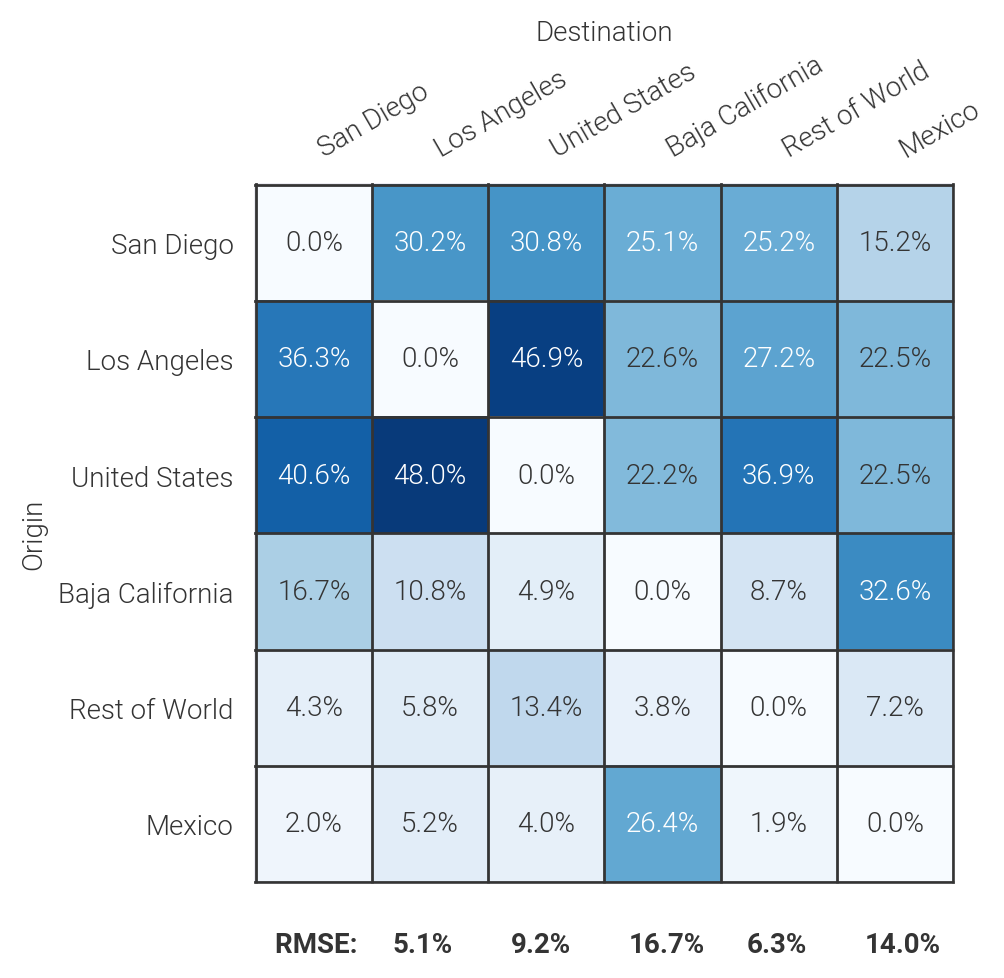

In [114]:
# Plot the results from one tree as a supplimental figure to describe the RMSE analysis.
example = test[np.random.choice( test.columns.get_level_values("treeId") )]
col_order = ["San Diego", "Los Angeles", "United States", "Baja California", "Rest of World", "Mexico"]
example = example.reindex( columns=col_order, index=col_order )

fig, ax = plt.subplots( dpi=200, figsize=(5,5) )
ax.imshow( example, cmap="Blues", vmin=0, vmax=0.5 )

ax.set_xticks( range( len( col_order ) ) )
ax.set_xticklabels( col_order, ha="left" )
ax.set_xlabel( "Destination" )
ax.xaxis.set_label_position('top')
ax.set_yticks( range( len( col_order ) ) )
ax.set_yticklabels( col_order )
ax.set_ylabel( "Origin" )

ax.tick_params( axis="x", rotation=30, labelbottom=False, labeltop=True )

for i in range( len( col_order ) ):
    for j in range( len( col_order ) ):
        value = example[col_order[i]][col_order[j]]
        ax.text(i, j, f"{value:.1%}", ha="center", va="center", color=COLOR if value < 0.25 else "w" )

for i, loc in enumerate( col_order ):
    if loc != "San Diego":
        rmse_res = get_comparison( (loc, "San Diego"), example )
        fig.text( 0.275 + 0.118 * i, 0, f"{rmse_res:.1%}", fontweight="bold" )

fig.text(0.275, 0, "RMSE: ", fontweight="bold" )

ax.set_xticks(np.arange(example.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(example.shape[0]+1)-.5, minor=True)
ax.grid(False)
ax.grid(which="minor", color=COLOR, linestyle='-', linewidth=1)

ax.set_ylim( 5.524, -0.524)
ax.set_xlim(-0.524, 5.524)

plt.tight_layout()
plt.savefig( "../analyses/plots/figureSX_rmse-diagram.pdf" )
plt.show()

In [96]:
example

endLocation,San Diego,Los Angeles,United States,Baja California,Rest of World,Mexico
startLocation,,,,,,
San Diego,0.000000,0.415663,0.465950,0.378601,0.413462,0.328244
Los Angeles,0.348348,0.000000,0.351254,0.185185,0.240385,0.137405
United States,0.342342,0.436747,0.000000,0.172840,0.278846,0.183206
Baja California,0.192192,0.069277,0.050179,0.000000,0.000000,0.244275
Rest of World,0.078078,0.045181,0.075269,0.000000,0.000000,0.106870
Mexico,0.039039,0.033133,0.057348,0.263374,0.067308,0.000000


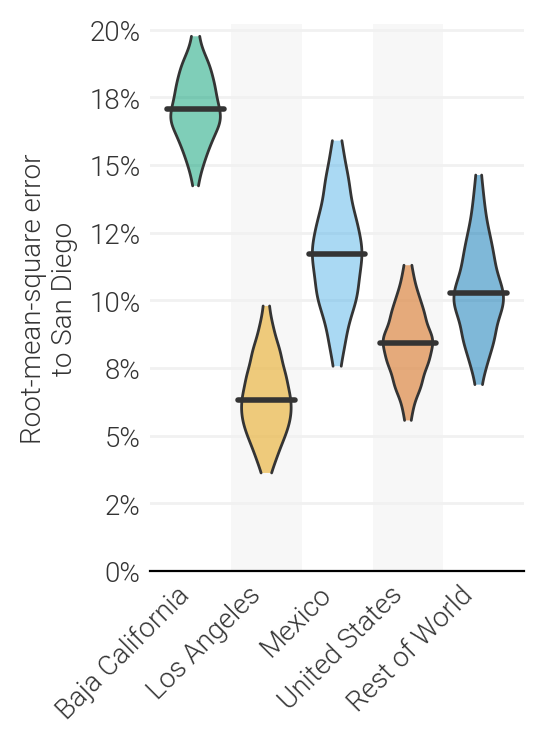

In [5]:
def plot_introduction_sources( ax, results ):
    for i, query in enumerate( results.columns ):
        data = results[query].to_numpy().ravel()
        data = data[~np.isnan(data)]
        data_median = np.median( data )

        hpdHi, hpdLo = hpd( data, 0.95 )
        y_grid = np.linspace( hpdLo, hpdHi, 101 )

        kde = gaussian_kde( data )
        x_grid = kde.evaluate( y_grid )
        x_grid = x_grid / x_grid.max() * 0.35

        ax.fill_betweenx( y_grid, [i-x for x in x_grid], [i+x for x in x_grid], edgecolor='none', alpha=0.5, zorder=99, facecolor=colors[query] )
        ax.plot( [i+x for x in x_grid], y_grid, color=COLOR, lw=1, zorder=100, solid_capstyle="round" )
        ax.plot( [i-x for x in x_grid], y_grid, color=COLOR, lw=1, zorder=100, solid_capstyle="round" )
        ln = ax.hlines( data_median, i-0.4, i+0.4, color=COLOR, linewidth=2, zorder=110)
        ln.set_capstyle( "round" )

    ax.set_xticks( range( len( results.columns ) ) )
    ax.set_xticklabels( results.columns, ha="right" )

    ax.axvspan( 0.5,1.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
    ax.axvspan( 2.5,3.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )

    basic_formatting( ax, which="y", ylabel="Root-mean-square error\nto San Diego", ysize=10, xsize=10, ylims=(0,0.202) )
    ax.tick_params( axis="x", bottom=False, which="both", rotation=45, pad=0 )
    ax.yaxis.set_major_formatter( ticker.PercentFormatter( xmax=1, decimals=0 ) )

fig, ax = plt.subplots( dpi=200, figsize=(3,4) )
plot_introduction_sources( ax, results )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_introduction-sources-sd.pdf" )
plt.show()

Calculate the number of jumps between San Diego and each other discrete state.

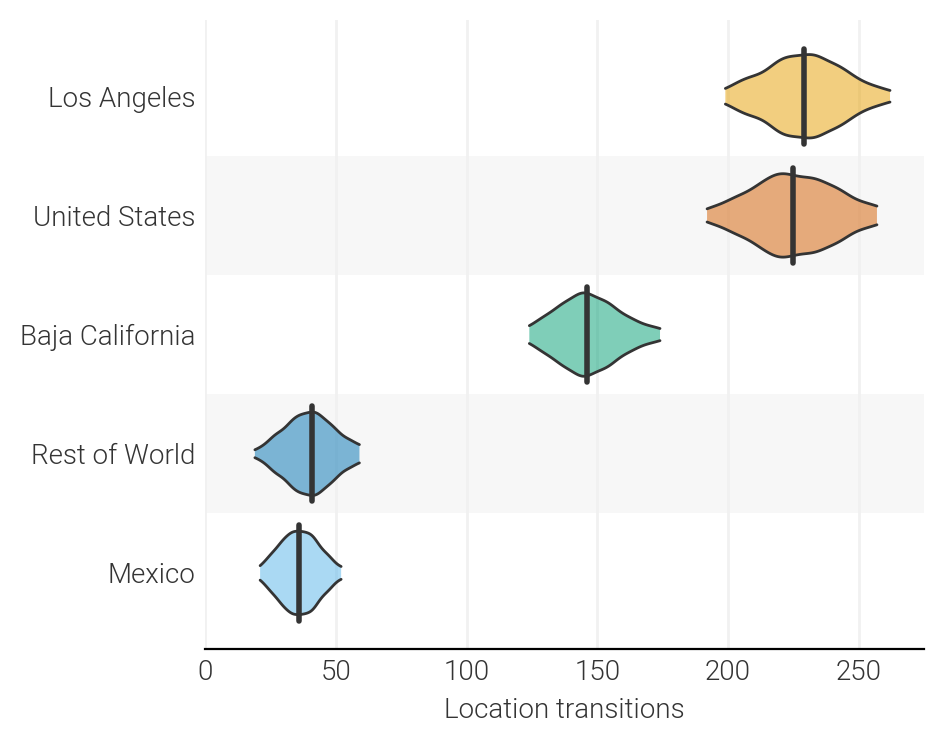

In [6]:
location = "San Diego"

sd_jumps = jumps.loc[(jumps["startLocation"]==location)|(jumps["endLocation"]==location)].copy()
sd_jumps.loc[sd_jumps["endLocation"]==location,"endLocation"] = sd_jumps["startLocation"]
sd_jumps["startLocation"] = location
sd_jumps = sd_jumps.groupby( ["treeId","endLocation"] )["time"].agg( "count" ).reset_index()

def plot_jumps_between( ax, j ):
    for i, query in enumerate( j.groupby( "endLocation" )["time"].median().sort_values().index ):
        data = j.loc[j["endLocation"]==query,"time"].to_numpy().ravel()
        data = data[~np.isnan(data)]
        data_median = np.median( data )

        hpdHi, hpdLo = hpd( data, 0.95 )
        x_grid = np.linspace( hpdLo, hpdHi, 101 )

        kde = gaussian_kde( data )
        y_grid = kde.evaluate( x_grid )
        y_grid = y_grid / y_grid.max() * 0.35

        ax.plot(x_grid, [i+y for y in y_grid], color=COLOR, lw=1, zorder=101, solid_capstyle="round" )
        ax.plot(x_grid, [i-y for y in y_grid], color=COLOR, lw=1, zorder=101, solid_capstyle="round" )

        ax.fill_between( x_grid, [i-y for y in y_grid], [i+y for y in y_grid], facecolor=colors[query], edgecolor='none', alpha=0.5, zorder=100 )
        ln = ax.vlines( data_median, i-0.4, i+0.4, color=COLOR, linewidth=2, zorder=110)
        ln.set_capstyle( "round" )

    ax.set_yticks( range( len( j.groupby( "endLocation" )["time"].median().sort_values().index ) ) )
    ax.set_yticklabels( j.groupby( "endLocation" )["time"].median().sort_values().index )

    ax.axhspan( 0.5,1.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
    ax.axhspan( 2.5,3.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )

    basic_formatting( ax, spines=["bottom"], which="x", xlabel="Location transitions", ysize=10, xsize=10, xlims=(0, 275) )
    ax.tick_params( axis="x", bottom=False, which="both", rotation=0, pad=0 )

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
plot_jumps_between( ax, sd_jumps )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_jumps-into-san-diego.pdf" )
plt.show()

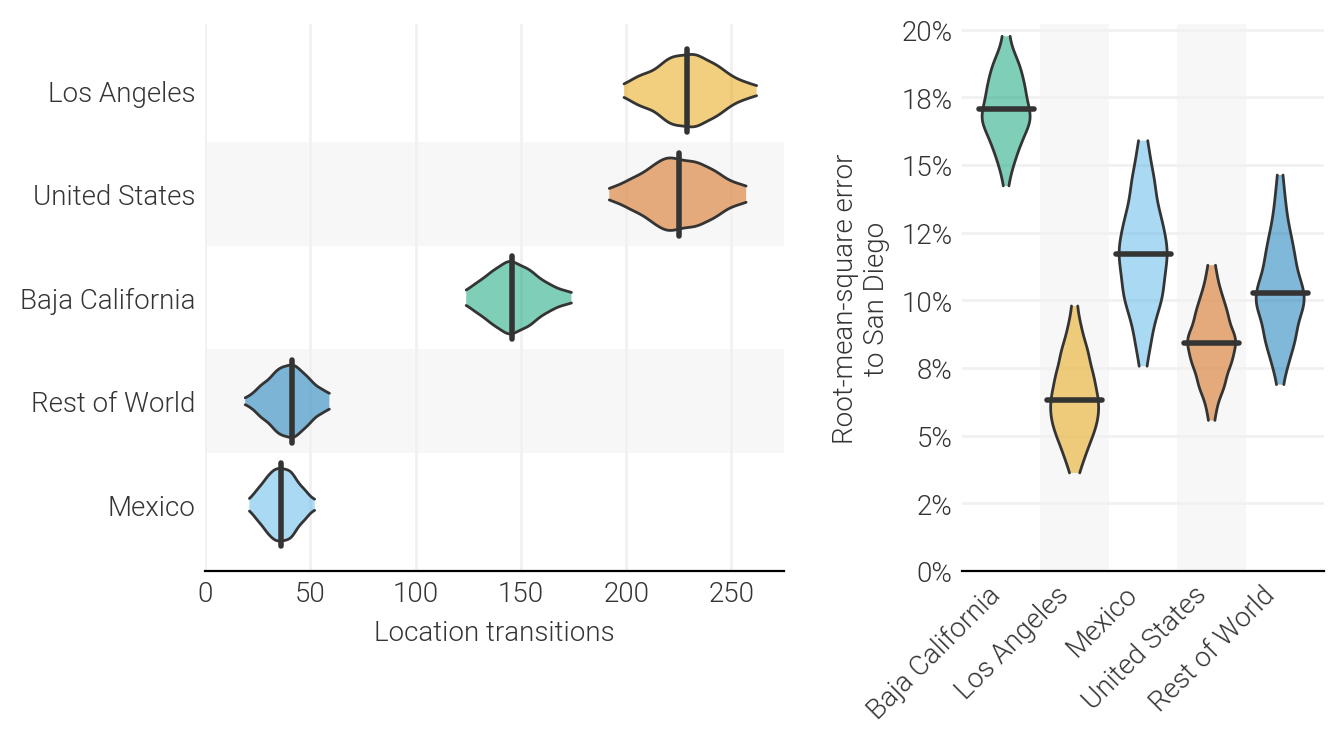

In [7]:
fig, ax = plt.subplots( dpi=200, figsize=(7,4), ncols=2, gridspec_kw={"width_ratios" : (2,1.25)} )
plot_jumps_between( ax[0], sd_jumps )
plot_introduction_sources( ax[1], results )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_jumps-sources-into-san-diego.pdf" )
plt.show()

Load in the median estimates from the permutation test

In [8]:
usecols = {
    "state" : "state",
    "c_counts.BajaCalifornia.SanDiego[1]" : "Baja California",
    "c_counts.LosAngeles.SanDiego[1]" : "Los Angeles",
    "c_counts.Mexico.SanDiego[1]" : "Mexico",
    "c_counts.RestofWorld.SanDiego[1]" : "Rest of World",
    "c_counts.UnitedStates.SanDiego[1]" : "United States",
}

permutation_loc = "../data/discrete_state_permutations/"
permutation = []
for num, log in enumerate( os.listdir( permutation_loc ) ):
    if log.endswith( ".log" ):
        log_file = pd.read_csv( os.path.join( permutation_loc, log ), header=3, sep="\t", usecols=usecols.keys() )
        log_file = log_file.loc[log_file["state"]>log_file["state"].max()*0.1]
        log_file = log_file.drop( columns=["state"] )
        log_file = log_file.rename( columns=usecols )
        log_file = log_file.median()
        log_file.name = num
        permutation.append( log_file )
permutation = pd.concat( permutation, ignore_index=False ).reset_index()
permutation.columns = ["location", "jumps" ]
permutation.head()

,location,jumps
0,Baja California,170.0
1,Los Angeles,168.0
2,Mexico,57.0
3,Rest of World,37.0
4,United States,353.0


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: cannot unpack non-iterable NoneType object

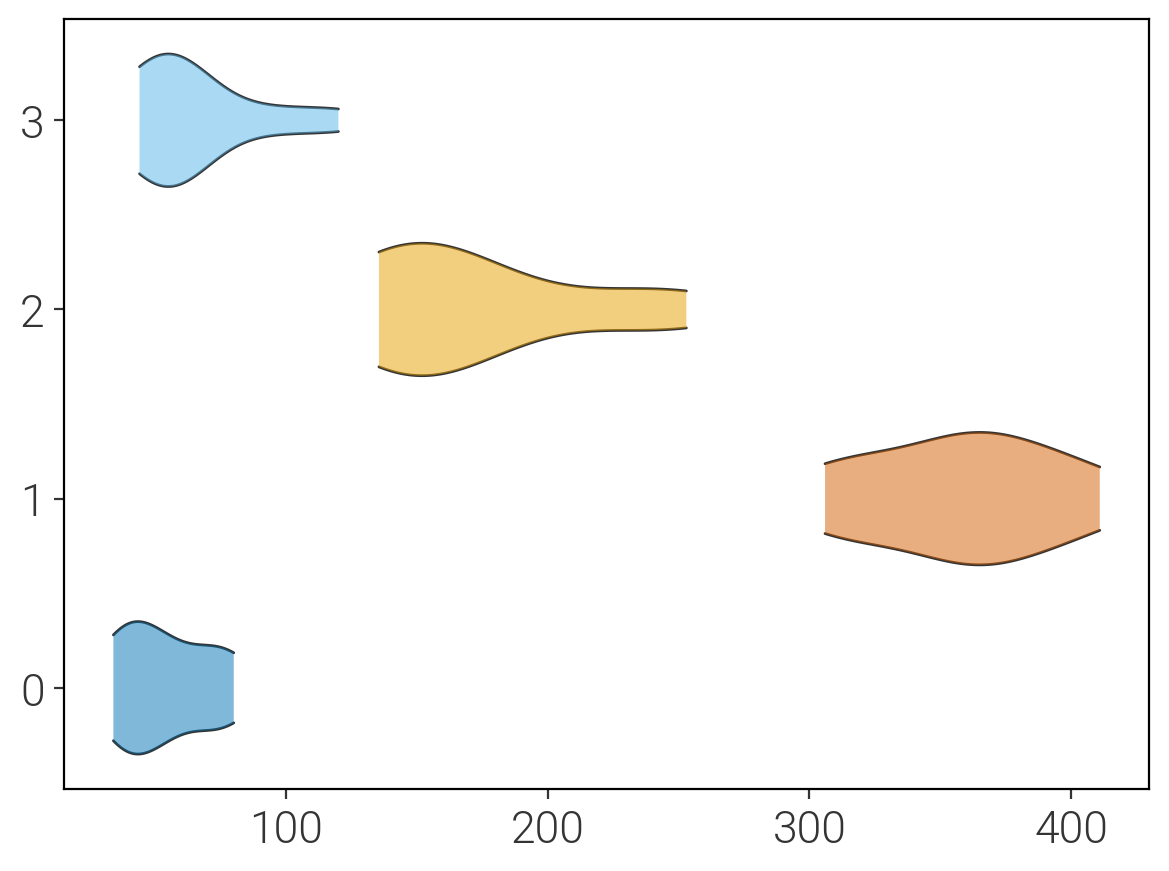

In [9]:
fig, ax = plt.subplots( dpi=200, figsize=(7,5) )
order = sd_jumps.groupby( "endLocation" )["time"].median().sort_values().index
medians = sd_jumps.groupby( "endLocation" )["time"].median().sort_values().reset_index()

for i, query in enumerate( order ):
    data = permutation.loc[permutation["location"]==query, "jumps"].to_numpy().ravel()
    data = data[~np.isnan(data)]
    data_median = np.median( data )

    hpdHi, hpdLo = hpd( data, 0.95 )
    x_grid = np.linspace( hpdLo, hpdHi, 101 )

    kde = gaussian_kde( data )
    y_grid = kde.evaluate( x_grid )
    y_grid = y_grid / y_grid.max() * 0.35

    ax.plot(x_grid, [i+y for y in y_grid], color=COLOR, lw=1, zorder=100, solid_capstyle="round" )
    ax.plot(x_grid, [i-y for y in y_grid], color=COLOR, lw=1, zorder=100, solid_capstyle="round" )

    ax.fill_between( x_grid, [i-y for y in y_grid], [i+y for y in y_grid], facecolor=colors[query], edgecolor='none', alpha=0.5, zorder=100 )

ln = ax.vlines( medians["time"], medians.index-0.4, medians.index+0.4, color=COLOR, linewidth=2, zorder=110 )
ln.set_capstyle( "round" )

ax.set_yticks( range( len( order ) ) )
ax.set_yticklabels( order )

basic_formatting( ax, which="x", xlabel="Median Markov jumps" )
ax.tick_params( axis="x", bottom=False, which="both", rotation=0, pad=0 )

plt.tight_layout()
#plt.savefig( "../analyses/plots/figure2_jumps-into-san-diego.pdf" )
plt.show()

In [ ]:
location = "San Diego"

sd_jumps = jumps.loc[(jumps["startLocation"]==location)|(jumps["endLocation"]==location)].copy()
sd_jumps.loc[sd_jumps["endLocation"]==location,"endLocation"] = sd_jumps["startLocation"]
sd_jumps["startLocation"] = location
plot_df = sd_jumps.pivot_table( index="date", columns="endLocation", values="startLocation", aggfunc="count", fill_value=0 )
plot_df = plot_df.apply( lambda x: savgol_filter( x, window_length=31, polyorder=3 ) )
plot_df = plot_df.clip( lower=0 )
plot_df = plot_df.apply( lambda x: x / x.sum(), axis=1 )
plot_df = plot_df.reindex( columns=sd_jumps["endLocation"].value_counts().sort_values().index )

jumps_mag = sd_jumps.pivot_table( index="date", values="startLocation", aggfunc="count", fill_value=0 )
jumps_mag["startLocation"] = savgol_filter( jumps_mag["startLocation"], window_length=31, polyorder=3 )
jumps_mag = jumps_mag / jumps_mag.max()

fig, ax = plt.subplots( figsize=(10,5), dpi=200, nrows=2, sharex=True, gridspec_kw={"height_ratios" : (0.2, 1), "hspace" : 0.05} )
ax[0].plot( jumps_mag.index, jumps_mag["startLocation"], color=COLOR, zorder=9 )
ax[0].fill_between( jumps_mag.index, jumps_mag["startLocation"], color=COLOR, alpha=0.5, zorder=8 )

ax[1].stackplot( plot_df.index, plot_df.T, labels=plot_df.columns, zorder=9, colors=[colors[i] for i in plot_df.columns], alpha=0.5, linewidth=2 )

baseline = np.zeros( len( plot_df ))
for i in plot_df:
    if i != plot_df.columns[-1]:
        ax[1].plot( plot_df.index, plot_df[i] + baseline, color=COLOR, zorder=10, linewidth=1 )
        baseline += plot_df[i]

legend = []
for col in reversed( plot_df.columns ):
    legend.append( Line2D([0], [0], linestyle='none', marker='o', color=colors[col], label=col, markersize=10 ) )

ax[0].legend( handles=legend, loc="upper center", bbox_to_anchor=(0,0,1,1.55), handletextpad=0.1, frameon=False, fontsize=10, ncol=len( legend ) )
basic_formatting( ax[1], spines=[], which="both", xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-06-01") ), ylims=(0,1), ylabel="Percentage of Markov jumps", xsize=10, ysize=10 )
timeseries_formatting( ax[1] )
ax[1].yaxis.set_major_formatter( ticker.PercentFormatter(xmax=1) )

basic_formatting( ax[0], spines=["bottom"], which="both", ylims=(0,1.05), ylabel="Density", xsize=10 )
ax[0].set_yticks( [0, 1] )
ax[0].set_yticklabels( [] )
ax[0].label_outer()

plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_jumps-between-sd-relative.pdf" )
plt.show()

# Rates

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_80162/1106714653.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rates = rates.where(np.tril(np.ones(rates.shape)).astype(np.bool))


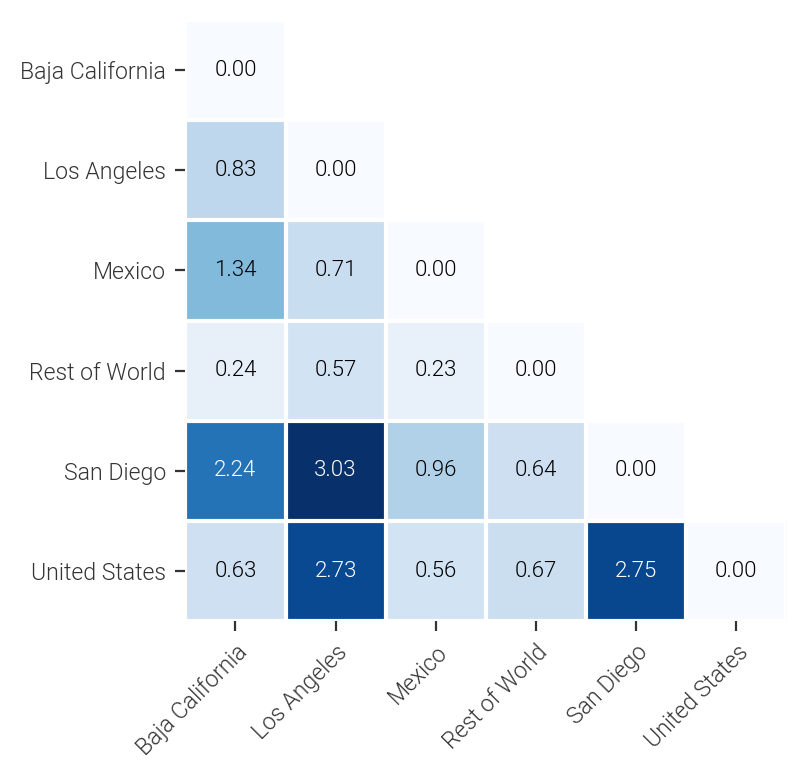

In [6]:
def calculate_rate_matrix( log_loc, header=3, metric="median", burnin=None ):

    rates = pd.read_csv( log_loc, header=3, sep="\t" )

    if burnin is None:


    rates = rates.loc[rates["state"] > burnin]
    rates = rates[[i for i in rates.columns if i.startswith( "Location.rates" )]]
    rates = rates.agg( metric )
    rates.name = metric
    rates = rates.reset_index()
    rates["from"] = rates["index"].apply( lambda x: x.split( "." )[-2] )
    rates["to"] = rates["index"].apply( lambda x: x.split( "." )[-1] )
    rates_rev = rates.copy()
    rates_rev[["from", "to"]] = rates[["to", "from"]]
    rates = pd.concat( [rates,rates_rev], ignore_index=True )
    rates = rates.pivot( index="from", columns="to", values=metric ).fillna( 0.0 )
    rates = rates.where(np.tril(np.ones(rates.shape)).astype(np.bool))
    return rates

def plot_matrix( mat, axis, title=None ):
    im = axis.imshow( mat, cmap="Blues" )
    axis.set_xticks( np.arange( mat.shape[0] ) )
    axis.set_yticks( np.arange( mat.shape[0] ) )
    axis.set_xticklabels( mat.index, fontsize="small" )
    axis.set_yticklabels( mat.index, fontsize="small" )
    axis.set_title( title  )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    axis.set_xticks(np.arange(mat.shape[1]+1)-.5, minor=True)
    axis.set_yticks(np.arange(mat.shape[0]+1)-.5, minor=True)
    axis.grid( which="minor", color="w", linestyle='-', linewidth=1.5 )
    axis.tick_params( which="minor", bottom=False, left=False)

    [axis.spines[j].set_visible(False) for j in ax.spines]

    for i in range( mat.shape[0] ):
        for j in range( mat.shape[0] ):
            if j <= i:
                value = mat.fillna(0).iloc[i, j]
                color = "k" if value < 1.75 else "w"
                text = axis.text( j, i, f"{value:.2f}", ha="center", va="center", color=color, fontsize=8 )

r = calculate_rate_matrix( "/Users/natem/Downloads/2022-08-05_exponential_fixed_discrete.log" )

fig, ax = plt.subplots(dpi=200)
mpl.rcParams['font.size']=10
plot_matrix( r, ax, None )
plt.tight_layout()
#plt.savefig( "../figures/transtion_heatmap.pdf" )
plt.show()

In [19]:
rates = pd.read_csv( "/Users/natem/Downloads/2022-08-05_exponential_fixed_discrete.log", header=3, sep="\t" )
burnin = rates["state"].max() * 0.1
rates = rates.loc[rates["state"] > burnin]
rates = rates[[i for i in rates.columns if i.startswith( "Location.rates" )]]
rates = rates.describe( percentiles=[0.025, 0.5, 0.975]).T
rates = rates.reset_index()
rates["first"] = rates["index"].apply( lambda x: x.split( "." )[2] )
rates["second"] = rates["index"].apply( lambda x: x.split( "." )[3] )
rates["result"] = rates.apply( lambda x: f"{x['50%']:.2f} ({x['2.5%']:.2f}-{x['97.5%']:.2f})", axis=1 )
rates = rates[["first", "second", "result"]]
rates.to_csv( "test.csv" )